Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/master/LICENSE.md)


# SHAP explanations

In this notebook we'll run an explainability analysis using SHAP and then we'll proceed to graph some summary plots of feature importance.

In [1]:
import pandas as pd
import matplotlib as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
import sys
sys.path.append("../utils")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from copy import copy

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.scanner.explanation_utils import explanations, construct_shap_dataframe
from certifai.common.utils.encoding import CatEncoder

In [2]:
# Example will use a simple logistic classifier on the German Credit dataset
all_data_file = "../datasets/german_credit_eval.csv"

df = pd.read_csv(all_data_file)

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)

def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'probability': [True], 'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = svm.SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

svm_model = build_model((encoder(X_train.values), y_train),
                        'Support Vector Machine',
                        'SVM',
                        test=(encoder(X_test.values), y_test))

logistic_model = build_model((encoder(X_train.values), y_train),
                        'Logistic classifier',
                        'logistic',
                        test=(encoder(X_test.values), y_test))

Model 'Support Vector Machine' accuracy is 0.77
Model 'Logistic classifier' accuracy is 0.77


In [3]:
# Wrap the models using their soft outputs for Certifai
from sklearn_soft_wrapper import SkLearnSoftWrapper

def _wrap_sklearn_classifier(classifier, encoder=None) -> CertifaiPredictorWrapper:
    return CertifaiPredictorWrapper(SkLearnSoftWrapper(classifier),
                                    soft_predictions=True,
                                    encoder=encoder,
                                    label_ordering=classifier.classes_)

svm_model_proxy = _wrap_sklearn_classifier(svm_model, encoder=encoder)
logistic_model_proxy = _wrap_sklearn_classifier(logistic_model, encoder=encoder)

In [4]:
# Create the scan object from scratch using the ScanBuilder class

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_use_case',
                                  prediction_task=task)

# Add our local models
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
scan.add_model(first_model)
second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)

# Add the explanation dataset - we're only going to bother extracting a small number here
expl_dataset = CertifaiDataset('explanation',
                               CertifaiDatasetSource.dataframe(df[:10]))
scan.add_dataset(expl_dataset)

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by marital status and age
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_evaluation_type('explainability')
scan.add_evaluation_type('explanation')
scan.evaluation_dataset_id = 'evaluation'
scan.explanation_dataset_id = 'explanation'

# Setup the explanation type. We want to run a shap-only explainability analysis.
scan.add_explanation_type('shap')
scan.primary_explanation_type = 'shap'
scan.remove_explanation_type('counterfactual')

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` would do) may be visualized in the console app
result = scan.run(write_reports=False)

Starting scan with model_use_case_id: 'test_use_case' and scan_id: 'e39d78aee966', total estimated time is 5 minutes
[--------------------] 2023-01-06 12:06:58.787168 - 0 of 6 reports (0.0% complete) - Running explainability evaluation for model: SVM, estimated time is 179 seconds
[###-----------------] 2023-01-06 12:11:17.542430 - 1 of 6 reports (16.67% complete) - Running explanation evaluation for model: SVM, estimated time is 23 seconds
[######--------------] 2023-01-06 12:11:45.785245 - 2 of 6 reports (33.33% complete) - Running atx evaluation for model: SVM
[##########----------] 2023-01-06 12:11:45.788095 - 3 of 6 reports (50.0% complete) - Running explainability evaluation for model: logistic, estimated time is 65 seconds
[#############-------] 2023-01-06 12:12:37.864217 - 4 of 6 reports (66.67% complete) - Running explanation evaluation for model: logistic, estimated time is 14 seconds
[################----] 2023-01-06 12:12:44.507380 - 5 of 6 reports (83.33% complete) - Runni

In [5]:
scores_df = construct_scores_dataframe(scores('explainability', result))
display(scores_df)

,context,explainability,Num features (1),Num features (10),Num features (2),Num features (3),Num features (4),Num features (5),Num features (6),Num features (7),Num features (8),Num features (9)
SVM,SVM,0.0,0.0,49.21875,0.0,0.0,0.0,0.0,0.00000,1.56250,17.1875,32.03125
logistic,logistic,0.0,0.0,31.25000,0.0,0.0,0.0,0.0,0.78125,10.15625,25.0000,32.81250


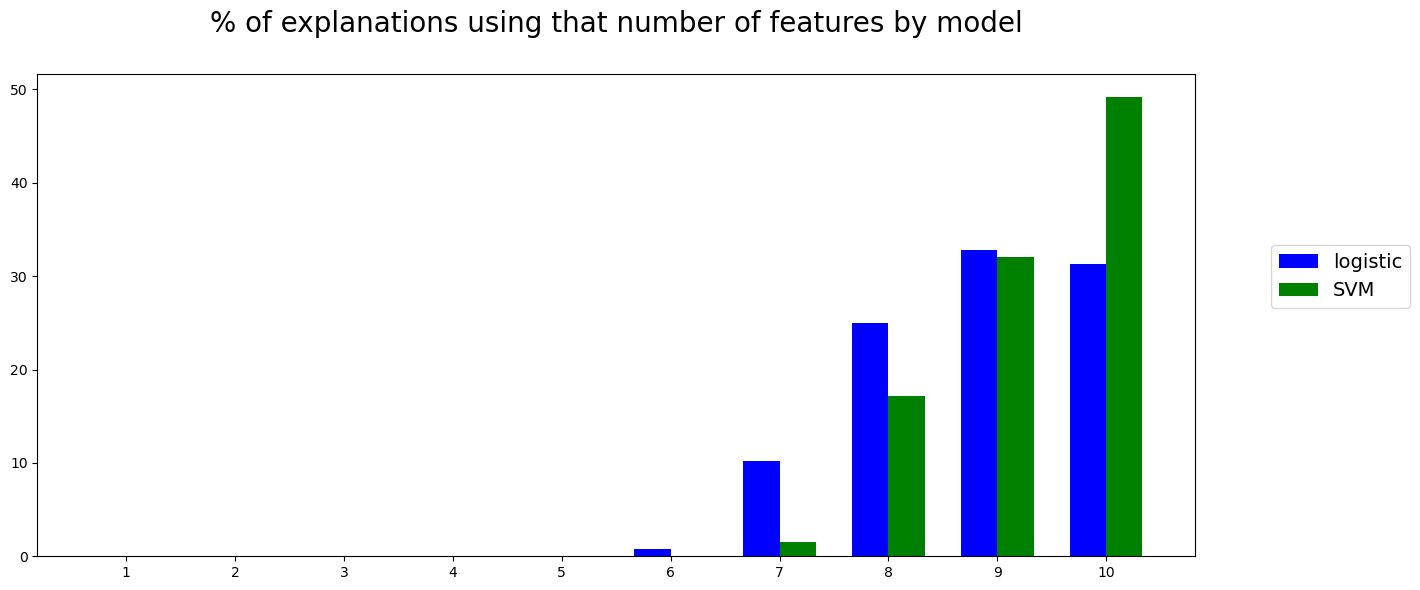

In [6]:
# Plot a histogram of number of features used in the shap explanations
%matplotlib inline
import matplotlib.pyplot as plt

# Here we'll extract the histogram of number of features used in the shap explanations
def get_feature_frequency(model_id):
    num_features = list(range(1, 11))
    percentages = []
    for n in num_features:
        percentages.append(scores_df[f'Num features ({n})'][model_id])
    
    return percentages, num_features

def plot_histogram(ax, model_id, color, model_idx, model_count):
    percentages, num_features = get_feature_frequency(model_id)

    ax.bar(np.array(num_features) + model_idx/(model_count+1),
           percentages,
           width=1./(model_count+1),
           color = color,
           label=model_id)

    ax.ylabel = 'Frequency'
    ax.set_xticks(np.array(num_features) + 1./(2*(model_count+1)))
    ax.set_xticklabels(num_features)

fig, ax = plt.subplots(figsize=[15,6])
ax.set_title('% of explanations using that number of features by model',
             fontsize=20,
             pad=30)

plot_histogram(ax, 'logistic', 'blue', 0, 2)
plot_histogram(ax, 'SVM', 'green', 1, 2)

fig.legend(fontsize=14, bbox_to_anchor=(.95,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8)  

plt.show()

In [7]:
# Let's look in detail at the explanations for each model of the first data point.
# First extract the explanations in a conveniently consumable form (the `ExplainedPrediction` object model,
# which is part of the Certifai toolkt API)
all_explanations = explanations(result)


## Individual Example Explanations

In the cell below we display detailed explanations for the first three examples for each model.  For each
explanation we display:
* The feature importance of the most significant features.  This chart is ordered from most to least important feature, and the coloration depicts whether the influence of that feature is towards the favorable outcome (green) or the unfavorable (red)
* The SHAP 'force plot' of the same data, again colored according to favorability
* A table of the feature values for the example being explained

*Note* - if you're viewing this notebook in its pre-run form rather than running it yourself, you'll need to select 'File -> Trust notebook' in the Jupyter menus to view the renderings below.

,model,row,prediction,expected class score,contribution,checkingstatus,duration,history,purpose,amount,...,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
0,SVM,1,1,0.64747,None,0.047339,0.033481,0.052349,-0.007859,0.011344,...,0.012104,0.016435,0.000000,0.0,-0.002748,-0.005352,0.001685,-0.03293,0.000000,0.095910
1,SVM,2,2,0.35253,None,0.209017,0.061970,0.023053,0.034392,-0.011261,...,0.011605,0.011059,-0.000606,0.0,-0.000919,-0.006347,0.013048,0.00000,0.004471,0.000495
2,SVM,3,1,0.64747,None,0.101329,-0.019883,-0.006160,0.093209,0.022903,...,-0.012024,-0.004422,0.000891,0.0,0.000000,0.006028,0.005642,0.00000,0.032586,0.000000


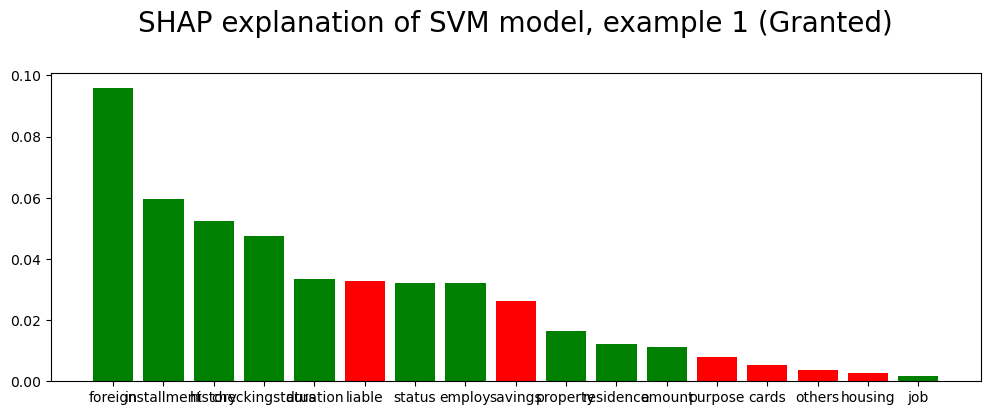

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... >= 200 DM / salary assignments for at least 1 year,6,critical account/ other credits existing (not at this bank),car (new),1343,... < 100 DM,.. >= 7 years,1,male : single,others - none,4,real estate,> 25 years,none,own,2,skilled employee / official,2,phone - none,foreign - no


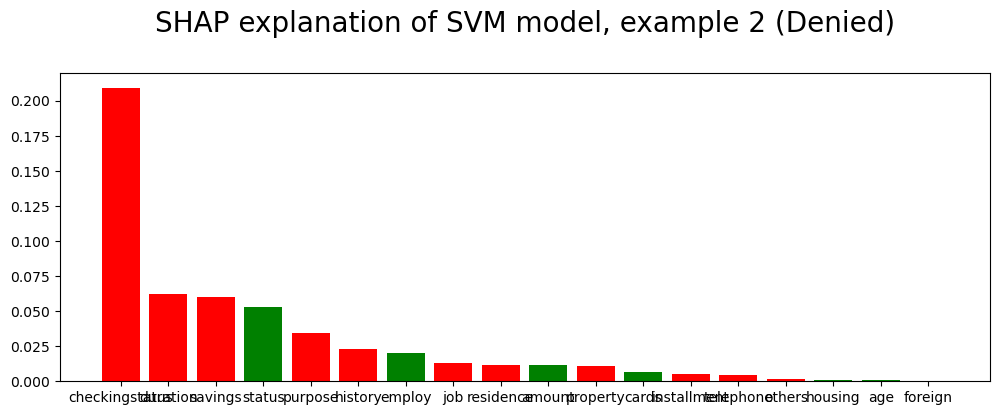

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... < 0 DM,28,existing credits paid back duly till now,car (new),4006,... < 100 DM,1 <= ... < 4 years,3,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,unskilled - resident,1,phone - none,foreign - yes


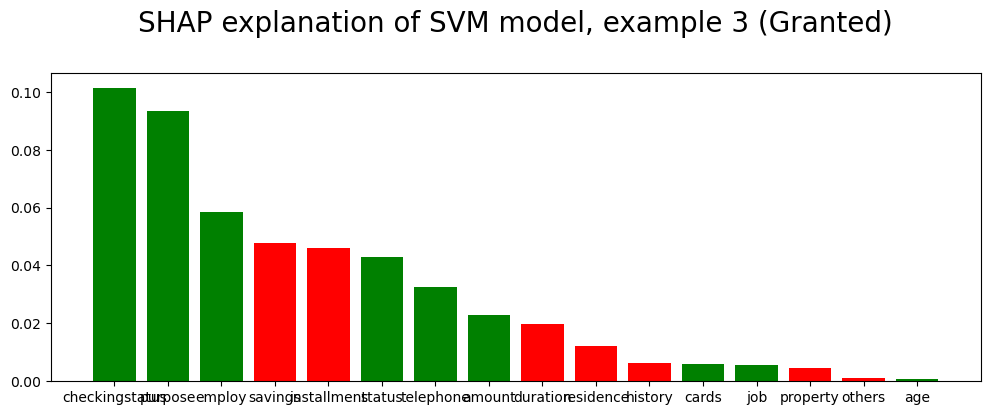

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,existing credits paid back duly till now,radio/television,2284,... < 100 DM,4 <= ... < 7 years,4,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,model,row,prediction,expected class score,contribution,checkingstatus,duration,history,purpose,amount,...,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
10,logistic,1,1,0.586506,None,0.060170,0.037371,0.088737,-0.031087,0.032355,...,0.002162,0.025840,0.000000,0.000000,0.00000,-0.013307,0.000000,-0.043358,-0.007563,0.107549
11,logistic,2,2,0.413494,None,0.115645,0.034992,0.007268,0.072524,0.028424,...,0.006830,0.011770,-0.002392,-0.002156,-0.00093,-0.006950,-0.011171,-0.000651,0.018523,0.000609
12,logistic,3,1,0.586506,None,0.155090,-0.009551,-0.003437,0.085441,0.023082,...,-0.005512,-0.006136,0.000000,0.002878,0.00000,0.005770,-0.002908,0.000000,0.044749,0.000000


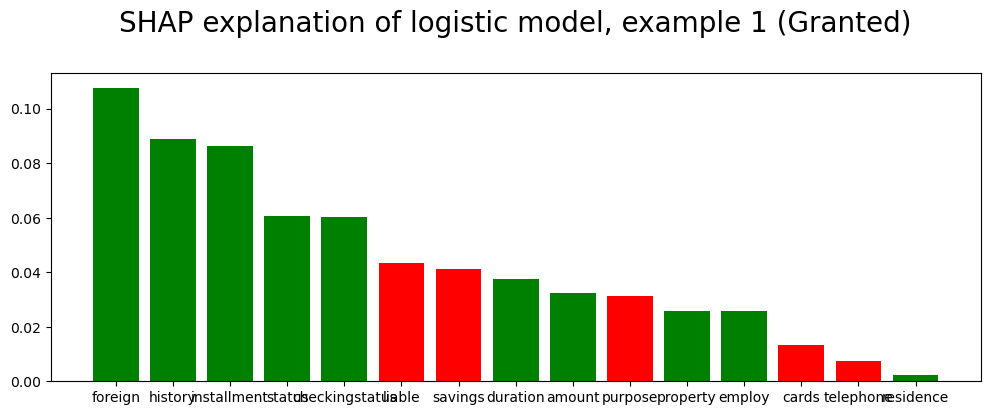

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... >= 200 DM / salary assignments for at least 1 year,6,critical account/ other credits existing (not at this bank),car (new),1343,... < 100 DM,.. >= 7 years,1,male : single,others - none,4,real estate,> 25 years,none,own,2,skilled employee / official,2,phone - none,foreign - no


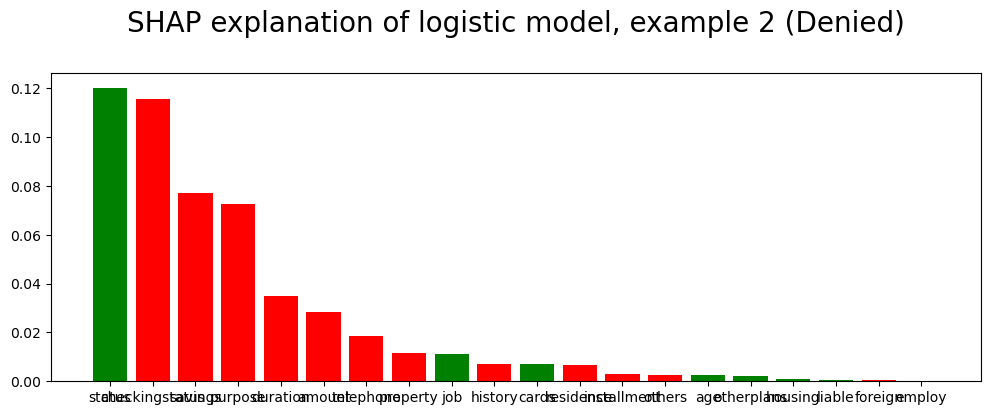

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... < 0 DM,28,existing credits paid back duly till now,car (new),4006,... < 100 DM,1 <= ... < 4 years,3,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,unskilled - resident,1,phone - none,foreign - yes


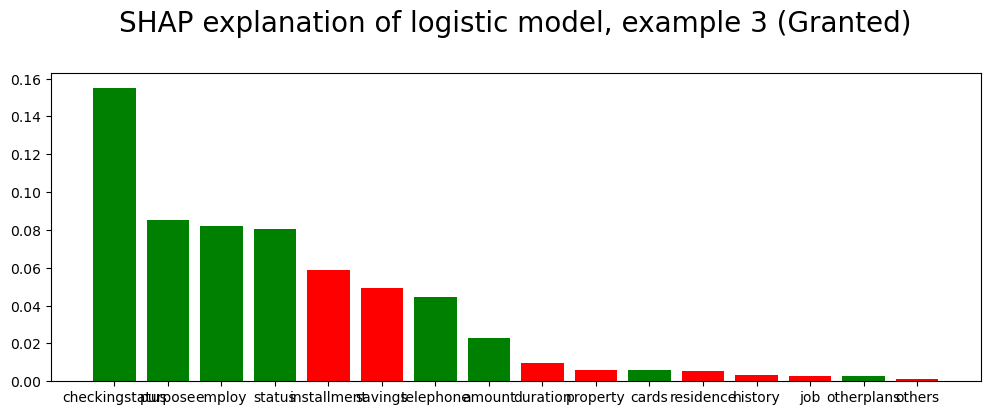

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,existing credits paid back duly till now,radio/television,2284,... < 100 DM,4 <= ... < 7 years,4,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


In [8]:
from IPython.display import display, HTML
import shap

shap.initjs()

# Display a SHAP force plot for one example
def display_force_plot(example, is_favorable):
    shap_explanation = example.explanation
    display(shap.force_plot(shap_explanation.class_expected_score,
                            shap_explanation.feature_weights,
                            example.instance,
                            plot_cmap = ["#008000", "#FF0000"] if is_favorable else ["#FF0000", "#008000"]))

# Method to display a table of the field values being explained and a histogram of the SHAP feature weights
# for a given example (displaying contributors towards the favorable outcome in green and those towards
# the unfavorable in red)
def display_shap_explanation(example,
                             title,
                             is_favorable):    
    example_as_pandas = pd.DataFrame(np.expand_dims(example.instance, axis=0),
                                     columns=example.field_names)
    colors = np.array(['red', 'green'] if is_favorable else ['green', 'red'])
    np_field_names = np.array(example.field_names)
    fig, ax = plt.subplots(figsize=[12,4])
    ax.set_title(title, fontsize=20, pad=30)
    impactful_features = np.where(example.explanation.feature_weights != 0.)[0]
    feature_perm = np.argsort(-np.abs(example.explanation.feature_weights[impactful_features]))
    ax.bar(np.arange(len(impactful_features)),
           np.abs(example.explanation.feature_weights[impactful_features])[feature_perm],
           color=colors[(example.explanation.feature_weights[impactful_features] > 0).astype('int')][feature_perm],
           tick_label=np_field_names[impactful_features][feature_perm])
    plt.show()
    
    display_force_plot(example, is_favorable)
    
    display(HTML(example_as_pandas.to_html(index=False)))

max_displayed_examples = 3  # Just display the first few here for illustration

from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 48em; }</style>"))

explanation_df = construct_shap_dataframe(all_explanations)
for model, model_explanations in all_explanations.items():
    model_df = explanation_df[explanation_df['model'] == model]
    display(model_df.head(max_displayed_examples))
    for idx in range(max_displayed_examples):
        granted = model_explanations[idx].prediction == 1
        display_shap_explanation(model_explanations[idx],
                                 f"SHAP explanation of {model} model, example {idx+1} ({'Granted' if granted else 'Denied'})",
                                 is_favorable=granted)